<a href="https://colab.research.google.com/github/yutan0565/Wake-up-Word_tensorflow2/blob/main/Wake_up_word_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작 전 세팅

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install python_speech_features
!pip install playsound
!pip install -q tensorflow-model-optimization
# !pip install pyaudio

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=5ace48755ac4d832415f37436ca9a0be5cb6b8b2a5a56c52d84756bf0100301a
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=7fe907b15dcc33dc2ece2187d06ff2eda591deb120997e3f861b62b46df8ac40
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
     |████████████████████████████████| 237 kB 8.4 MB/s 


In [4]:
base_path = "/content/drive/MyDrive/"
#base_path = "./"

# Data Augmentation

In [4]:
import soundfile as sf
import os
from os import listdir
from os.path import isdir, join
import librosa
import numpy as np
import shutil
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt

dataset_path = base_path + 'custum_dataset'

# 모든 데이터에 대해서 rate 만큼 augmentation 진행
# rate = 0.2 면,    총 데이터는 원본 : aug = 10 : 6
aug_rate = 0.9
non_target_list = ['_background_noise_', '.ipynb_checkpoints' ]


In [5]:
def plot_time_series(data, title):
    fig = plt.figure(figsize=(7, 4))
    plt.title(title+'  wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(data)), data)
    plt.show()

In [6]:
# Whit Noise
# 기존 소리에 잡음을 넣어줌
def adding_white_noise(data, type, count, sr=16000, noise_rate=0.001):
    # noise 방식으로 일반적으로 쓰는 잡음 끼게 하는 겁니다.
    sig, sr = librosa.load(data, sr=16000)
    wn = np.random.randn(len(sig))
    data_wn = sig + noise_rate*wn
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_white_noise'+'{0:04d}'.format(count)+'.wav', data_wn, sr)
    return data_wn

In [7]:
#stretch_sound
# 테이프 늘어진 것처럼 들린다.
def stretch_sound(data, type, count, sr=16000, rate=0.8):
    sig, sr = librosa.load(data, sr=16000)
    stretch_data = librosa.effects.time_stretch(sig, rate)
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_stretch_sound'+'{0:04d}'.format(count)+'.wav', stretch_data, sr)
    return stretch_data

In [8]:
# minus_sound
# x 축 기준으로 뒤집기 (사람에게는 똑같이 들림)
def minus_sound(data, type, count, sr=16000):
    sig, sr = librosa.load(data, sr=16000)
    temp_numpy = (-1)*sig
    sf.write( base_path+'augmentation_dataset/' + type +'/'+type+'_reverse_data'+'{0:04d}'.format(count)+'.wav', temp_numpy, sr)
    return temp_numpy

In [9]:
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]
for no_tar in non_target_list:
  if no_tar in target_list:
    target_list.remove(no_tar)

print(target_list)

for index, type in enumerate(target_list):
  print('/'.join([dataset_path, type])) 
  type_path = '/'.join([dataset_path, type])
  if not os.path.exists(base_path+'augmentation_dataset'):
            os.makedirs(base_path+'augmentation_dataset')

  if not os.path.exists(base_path+'augmentation_dataset/' + type):
            os.makedirs(base_path+'augmentation_dataset/' + type)
  all_file = listdir(type_path)
  count = 1
  aug_cut = len(all_file) * aug_rate
  for file_name in all_file:
    if count > aug_cut:
      break
    file_path =  type_path + "/"+file_name
    print(file_path, count)
    adding_white_noise(file_path, type, count)
    stretch_sound(file_path, type, count)
    minus_sound(file_path, type, count)
    copy_tree(type_path, base_path+'augmentation_dataset/' + type )
    count += 1

['hi_sungwoo', 'hey_tantan', 'no', 'hi_yutan']
/content/drive/MyDrive/custum_dataset/hi_sungwoo
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0007_hi_sungwoo.wav 1
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0002_hi_sungwoo.wav 2
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0016_hi_sungwoo.wav 3
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0006_hi_sungwoo.wav 4
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0003_hi_sungwoo.wav 5
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0011_hi_sungwoo.wav 6
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0004_hi_sungwoo.wav 7
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0017_hi_sungwoo.wav 8
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0009_hi_sungwoo.wav 9
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0005_hi_sungwoo.wav 10
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0008_hi_sungwoo.wav 11
/content/drive/MyDrive/custum_dataset/hi_sungwoo/voice0015_hi_sung

sr: 16000 , sig shape: (44033,)
length: 2.7520625 secs


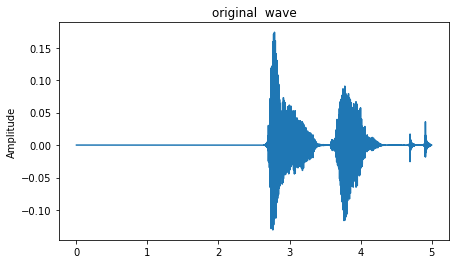

In [10]:
type = "hi_yutan"
file = base_path+"/custum_dataset/hi_yutan/voice0015_hi_yutan.wav"

# a = adding_white_noise(file, type)
# b= stretch_sound(file, type)
# c= minus_sound(file, type)

sig, sr = librosa.load(file, sr=16000)
print('sr:', sr, ', sig shape:', sig.shape)
print('length:', sig.shape[0]/float(sr), 'secs')

plot_time_series(sig, "original")
# plot_time_series(a,"Noise")
# plot_time_series(b,"Stretch")
# plot_time_series(c,"Reverse")

# 데이터 나눠 주기

In [5]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features
import librosa.display
import seaborn as sns
from sklearn import metrics
#from playsound import playsound

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
# import tensorflow_model_optimization as tfmot
from tensorflow import lite

np.random.seed(77)

In [6]:
# 데이터가 저장되어 있는 경로 ( class 별로 묶여 있는 곳)
dataset_path = base_path + 'augmentation_dataset' # custum_dataset

# train, valid, test 나눠 주기
val_ratio = 0.1
test_ratio = 0.2

print(dataset_path)

# 여기다가는 내가 사용하지 않은 class 이름들 넣어두기 - 학습 시간이 너무 오래 걸리는 경우
non_target_list = ['_background_noise_', '.ipynb_checkpoints' ]

# 폴더명 = target ,  target이 들어가 있는 list 생성
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]
for no_tar in non_target_list:
  if no_tar in target_list:
    target_list.remove(no_tar)
print(target_list)


filenames = []
y = []
for index, target in enumerate(target_list):
    print('/'.join([dataset_path, target]))  # class 에 맞는 폴더 이름 넣어주기
    filenames.append(listdir('/'.join([dataset_path, target])))
    y.append(np.ones(len(filenames[index])) * index) 

/content/drive/MyDrive/augmentation_dataset
['hi_sungwoo', 'hey_tantan', 'no', 'hi_yutan']
/content/drive/MyDrive/augmentation_dataset/hi_sungwoo
/content/drive/MyDrive/augmentation_dataset/hey_tantan
/content/drive/MyDrive/augmentation_dataset/no
/content/drive/MyDrive/augmentation_dataset/hi_yutan


In [7]:
print(y)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [8]:
# 하나로 쭉 나열 하기
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# 여기부터 분배를 잘 해줘야함
# file 모아둔거 한번 섞어 주기
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [9]:
print(len(filenames_train), len(y_orig_train))
print(len(filenames_val), len(y_orig_val))
print(len(filenames_test), len(y_orig_test))

476 476
68 68
136 136


# MFCC feature 추출

In [10]:
sample_rate = 16000
wav_time = 1.2 #초단위

sample_cut = int(sample_rate*wav_time)  # 이거    sample_rate랑, 다른 변수랑 섞어서 만들기뒤에서 얼마 만큼 자를지 정해야함)
click = int(16000*0.1)

num_mfcc=20   # frame 몇개로 할것인가
n_fft=2048
hop_length=512
len_mfcc = 38


ffts = []
stfts = [] 
f_ffts = []
log_specs = []
MFCCs_list = []

def get_librosa_mfcc(path):
    #waveforms.append([signal, sample_rate]) 
    # FFT -> power spectrum
    # perform Fourier transform

    sig, sr = librosa.core.load(path, sample_rate)
    signal = sig[-sample_cut-click:-click]
#     print('sr:', sr, ', sig shape:', sig.shape)
#     print('length:', sig.shape[0]/float(sr), 'secs')
#     plot_time_series(signal, "original")
    
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))
    f_ffts.append([frequency, magnitude])
    
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    
    # half frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    ffts.append([left_f, left_spectrum])

    #performing Short-time FT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    stfts.append([spectrogram, sample_rate, hop_length])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    log_specs.append([log_spectrogram, sample_rate, hop_length])
    MFCCs = librosa.feature.mfcc(signal, sample_rate, 
                                 n_mfcc=num_mfcc,
                                 n_fft=n_fft,
                                 hop_length=hop_length)
    MFCCs_list.append([MFCCs, sample_rate, hop_length])
    return MFCCs

In [ ]:
# 지금 내가 가지고 있는 것을 다 변환 했을때  동일한 크기의 mfcc 파일이 나오는가, 이상한거는 버려주기
prob_cnt = 0  
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    # if index >= 500:
    #     break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], filename)
    
    # Create MFCCs
    mfccs = get_librosa_mfcc(path)
    #print("mfccs 크기 :",mfccs.shape)

    if mfccs.shape[1] == len_mfcc:    # 지금은 40으로 설정되어 있음, ///  길이가 부족하면 나중에 버려야함
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
    print()


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


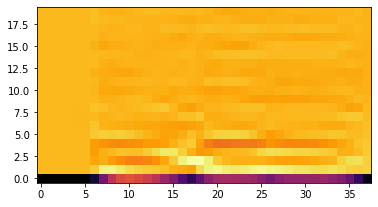

In [12]:
# 내가 확인 할 부분
idx = 1

# Create path from given filename and target item
path = '/'.join([dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx]])

# mfcc 만들기
mfccs = get_librosa_mfcc(path)

# MFCC 그림으로 보기
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# # 소리 확인
# print(target_list[int(y_orig_train[idx])])
# print(path)
# playsound(path)

In [13]:
# 학습 하기 전에 미리 모든 소리에 대해서 feature 추출해서 준비 해두는 단계, inpu을 맞추려고 
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = "/".join([dataset_path, target_list[int(in_y[index])], 
                    filename])
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = get_librosa_mfcc(path)

        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [14]:
x_train, y_train, prob_train = extract_features(filenames_train, y_orig_train)
x_val, y_val, prob_val = extract_features(filenames_val, y_orig_val)
x_test, y_test, prob_test = extract_features(filenames_test, y_orig_test)

print("Train 잃은거{}".format(prob_train / len(y_orig_train)))
print("Valid 잃은거{}".format(prob_val / len(y_orig_val)))
print("Test 잃은거{}".format(prob_test / len(y_orig_test)))

Train 잃은거0.0
Valid 잃은거0.0
Test 잃은거0.0


In [15]:
print(y_train)
print(y_val)
print(y_test)

[0.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 3.0, 3.0, 1.0, 2.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 3.0, 1.0, 3.0, 1.0, 3.0, 2.0, 2.0, 1.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0, 2.0, 1.0, 0.0, 3.0, 1.0, 2.0, 0.0, 2.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 3.0, 0.0, 1.0, 2.0, 0.0, 3.0, 3.0, 3.0, 0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 3.0, 1.0, 3.0, 1.0, 1.0, 0.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 1.0, 3.0, 3.0, 2.0, 3.0, 2.0, 0.0, 2.0, 1.0, 3.0, 1.0, 3.0, 0.0, 3.0, 2.0, 0.0, 1.0, 0.0, 3.0, 2.0, 3.0, 1.0, 0.0, 3.0, 3.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 3.0, 0.0, 2.0, 1.0, 0.0, 2.0, 3.0, 0.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 0.0, 0.0, 3.0, 3.0, 1.0, 2.0, 2.0, 1.0, 3.0, 0.0, 1.0, 1.0, 3.0, 1.0, 0.0, 0.0, 2.0,

In [16]:
wake_word = 'hi_yutan'
wake_word_index = target_list.index(wake_word)
print(wake_word_index)

3


In [17]:
# print(np.array(x_train).shape)
# print(np.array(y_train).shape)
# print(np.array(x_val).shape)
# print(np.array(y_val).shape)
# print(np.array(x_test).shape)
# print(np.array(y_test).shape)

In [18]:
# 학습에 사용할 모든 - MFCC 까지 모두 진행한 정보들
#저장 할 곳
np.savez(base_path +"mfcc_set.npz", 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# 데이터 전처리

In [19]:
# 나중에 저장할 모델 - 2진 분류
model_filename = 'hi_yutan_original_model.h5'
wake_word = 'hi_yutan'
feature_sets = np.load( base_path + "mfcc_set.npz")

# 저장되어 있는 mfcc feature 들 불러 오기
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [20]:
# 아직 변형 하기 이전 상태
print(y_train)
print(y_val)
print(y_test)

[0. 0. 1. 1. 0. 3. 1. 3. 3. 3. 3. 2. 1. 3. 3. 1. 2. 3. 0. 3. 3. 3. 1. 1.
 2. 3. 1. 1. 0. 1. 0. 0. 2. 0. 3. 1. 0. 0. 3. 0. 0. 0. 2. 3. 1. 3. 1. 3.
 2. 2. 1. 2. 3. 2. 0. 1. 3. 2. 1. 0. 3. 1. 2. 0. 2. 1. 3. 1. 1. 3. 3. 3.
 0. 0. 1. 3. 0. 0. 3. 0. 1. 2. 0. 3. 3. 3. 0. 1. 1. 2. 2. 0. 0. 3. 1. 3.
 1. 1. 0. 3. 1. 3. 3. 1. 1. 3. 3. 1. 0. 3. 0. 0. 0. 0. 1. 0. 0. 3. 1. 3.
 3. 2. 3. 2. 0. 2. 1. 3. 1. 3. 0. 3. 2. 0. 1. 0. 3. 2. 3. 1. 0. 3. 3. 3.
 1. 2. 1. 3. 1. 0. 0. 1. 0. 0. 0. 3. 3. 3. 0. 1. 1. 0. 3. 1. 1. 3. 0. 2.
 1. 0. 2. 3. 0. 3. 1. 1. 1. 3. 1. 1. 3. 3. 3. 0. 0. 3. 3. 1. 2. 2. 1. 3.
 0. 1. 1. 3. 1. 0. 0. 2. 3. 0. 3. 0. 3. 3. 3. 3. 1. 0. 3. 3. 1. 0. 3. 0.
 0. 0. 1. 3. 2. 3. 3. 3. 3. 1. 3. 2. 1. 0. 3. 1. 1. 3. 0. 0. 0. 2. 0. 2.
 3. 1. 1. 3. 2. 1. 3. 2. 1. 2. 3. 0. 1. 3. 0. 1. 1. 0. 3. 0. 1. 0. 1. 0.
 2. 0. 0. 0. 0. 1. 2. 1. 1. 2. 3. 0. 0. 1. 0. 3. 0. 3. 3. 1. 1. 0. 3. 3.
 1. 3. 1. 1. 1. 2. 2. 2. 1. 3. 3. 0. 3. 1. 0. 1. 1. 2. 3. 1. 1. 0. 1. 3.
 0. 1. 0. 2. 3. 1. 0. 1. 3. 3. 3. 2. 0. 2. 1. 3. 2.

In [21]:
# 내가 수행 하고 싶은 "기동어" 설정
# index (나는 하나니까 0) 이면, True 또는 False 반환 해주기 - 1아니면 0 ]
# wake up word index와 같은  부분은 1로 바꿔주고(True), 나머지 데이터는 그냥 0으로 처리 함

wake_word_index = target_list.index(wake_word)

y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

print(wake_word_index)
print(y_train)
print(y_val)
print(y_test)

3
[0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 

In [22]:
# CNN 에 넣기 이전에 Channel을 1로 만들어주기

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


# input shape 설정 해주기
sample_shape = x_test.shape[1:]
print(sample_shape)

(476, 20, 38, 1)
(68, 20, 38, 1)
(136, 20, 38, 1)
(20, 38, 1)


# 모델 구축 및 학습

In [23]:
# 모델 Conv-layer 
conv_layer = keras.Sequential([
                             layers.Conv2D(32, (2, 2), activation = 'relu', input_shape = sample_shape),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Conv2D(64, (2, 2), activation='relu'),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Conv2D(128, (2, 2), activation='relu'),
                             layers.MaxPooling2D(pool_size=(2, 2))
                             
                             ])


# FC layer는 다른거 사용   --  Class 10 개 분류
fc_layer = keras.Sequential([
                             layers.Flatten(),
                             layers.Dense(256, activation = 'relu'),
                             layers.Dense(256, activation = 'relu'),
                             layers.Dense(64, activation = 'relu'),
                             layers.Dropout(0.5),
                             layers.Dense(1, activation = "sigmoid")
                             ])

model = keras.Sequential([conv_layer,
                          fc_layer
                          ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1, 3, 128)         41312     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 180865    
                                                                 
Total params: 222,177
Trainable params: 222,177
Non-trainable params: 0
_________________________________________________________________


In [24]:
print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))

Val 에서 1의 비율 : 38.24%
Test 에서 1의 비율 : 30.15%


In [25]:
# Callback 함수 지정 해주기      학습하는 동안 설정해줄것
early_stop = EarlyStopping(patience=50) 
mc = ModelCheckpoint(base_path + "best_model/wake_up_word_model", 
                     save_best_only=True,
                     monitor = 'val_loss',
                     verbose = 1,
                     mode = 'min') 

reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=0.5, 
                               patience=5
                               ) 

#optimizer 조정 해주기
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [26]:
# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
history = model.fit(x_train, y_train,
          epochs= 1000,
          verbose=1,
          batch_size=16,
          #validation_split = 0.1
          validation_data = (x_val, y_val),
          callbacks = [early_stop, reduce_lr , mc]  # early_stop,
          )

Epoch 1/1000
27/30 [==========================>...] - ETA: 0s - loss: 3.9023 - accuracy: 0.4444
Epoch 1: val_loss improved from inf to 1.28646, saving model to /content/drive/MyDrive/best_model/wake_up_word_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/best_model/wake_up_word_model/assets
30/30 [==============================] - 5s 135ms/step - loss: 3.7105 - accuracy: 0.4643 - val_loss: 1.2865 - val_accuracy: 0.4853 - lr: 1.0000e-05
Epoch 2/1000
28/30 [===========================>..] - ETA: 0s - loss: 2.6541 - accuracy: 0.5424
Epoch 2: val_loss did not improve from 1.28646
30/30 [==============================] - 1s 17ms/step - loss: 2.5785 - accuracy: 0.5483 - val_loss: 1.3248 - val_accuracy: 0.6176 - lr: 1.0000e-05
Epoch 3/1000
27/30 [==========================>...] - ETA: 0s - loss: 2.2687 - accuracy: 0.5880
Epoch 3: val_loss improved from 1.28646 to 1.05037, saving model to /content/drive/MyDrive/best_model/wake_up_word_model
INFO:tensorflow:Assets written to: /c

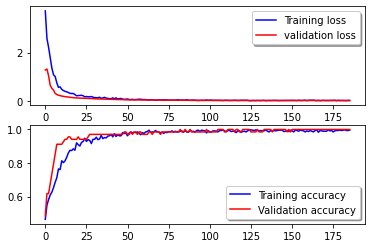

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

# 데이터 불균형으로 인해, val에 있는게 성능이 더 좋아보일 수도 있음

In [28]:
# 학습한거에서 test 어떻게 나오는지 확인 해보기
model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
for i in range(0,len(y_test) ):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.00105745]]
Answer: 0.0  Prediction: [[0.0065358]]
Answer: 0.0  Prediction: [[0.00674203]]
Answer: 0.0  Prediction: [[0.00498551]]
Answer: 0.0  Prediction: [[9.362379e-05]]
Answer: 0.0  Prediction: [[0.00858113]]
Answer: 1.0  Prediction: [[0.99305177]]
Answer: 1.0  Prediction: [[0.99841815]]
Answer: 1.0  Prediction: [[0.9815035]]
Answer: 1.0  Prediction: [[0.99961084]]
Answer: 0.0  Prediction: [[4.422361e-05]]
Answer: 1.0  Prediction: [[0.9941728]]
Answer: 0.0  Prediction: [[0.00033739]]
Answer: 0.0  Prediction: [[0.0028666]]
Answer: 0.0  Prediction: [[8.735631e-05]]
Answer: 1.0  Prediction: [[0.99934256]]
Answer: 1.0  Prediction: [[0.84518814]]
Answer: 0.0  Prediction: [[0.00011371]]
Answer: 1.0  Prediction: [[0.99559104]]
Answer: 0.0  Prediction: [[0.00587571]]
Answer: 1.0  Prediction: [[0.9998702]]
Answer: 1.0  Prediction: [[0.98475623]]
Answer: 0.0  Prediction: [[0.00019291]]
Answer: 0.0  Prediction: [[0.00630781]]
Answer: 0.0  Prediction: [[0.00114444]]

In [29]:
loss, acc = model.evaluate(x=x_test, y=y_test)
print("loss=",loss)
print("acc=",acc)

5/5 [==============================] - 0s 9ms/step - loss: 0.0735 - accuracy: 0.9779
loss= 0.07352612912654877
acc= 0.9779411554336548


In [30]:
print(x_test.shape, y_test.shape)
print(y_test)

(136, 20, 38, 1) (136,)
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.]


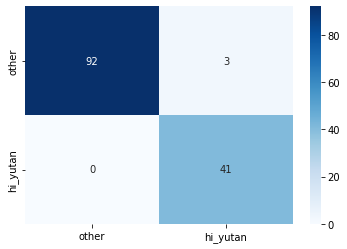

Thres - hold : 0.5
Test Accureacy:  0.9779411764705882
Test Precision:  0.9318181818181818
Test Recall:  1.0
Test F1 score:  0.9647058823529412
Val 에서 1의 비율 : 38.24%
Test 에서 1의 비율 : 30.15%


In [31]:
Y_pred = model.predict(x_test)

thres_hold = 0.5
predictions = []
for result in Y_pred:
  if result > thres_hold:
      predictions.append(1)
  else:
      predictions.append(0)



label = ["other", "hi_yutan"]

confusion_mtx = metrics.confusion_matrix(y_test,predictions)
sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = label,
            yticklabels = label,
            cmap='Blues')
plt.show()
print("Thres - hold : {}".format(thres_hold))
print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
print('Test Precision: ',metrics.precision_score( y_test,predictions))
print('Test Recall: ',metrics.recall_score( y_test,predictions ))
print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))

# 기본 tflite 변환

In [32]:
tflite_file_path = base_path + 'tflite_model/wake_word_hi_yutan_lite.tflite'

model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_file_path, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp2w7rne7w/assets


893484

In [33]:
tflite_file_path = base_path + 'tflite_model/wake_word_hi_yutan_lite.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'serving_default_sequential_input:0', 'index': 0, 'shape': array([ 1, 20, 38,  1], dtype=int32), 'shape_signature': array([-1, 20, 38,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 27, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


# Quantization 수행

In [35]:
# Quantization을 위한 point 설정
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

In [36]:
quant_tflite_file_path = base_path + 'tflite_model/quant_wake_word_hi_yutan_lite.tflite'
model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')

# int 8 로 quantization 진행하기
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

open(quant_tflite_file_path, 'wb').write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpo2fmoqy3/assets


INFO:tensorflow:Assets written to: /tmp/tmpo2fmoqy3/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


235912

In [37]:
# Quantization 모델의 input, output 변환 잘 되었는지 확인 하기
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


#Pruning 수행

In [40]:
!pip install tempfile

ERROR: Could not find a version that satisfies the requirement tempfile (from versions: none)
ERROR: No matching distribution found for tempfile


In [41]:
model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

# Pruning을 위한 변수 설정
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 32
epochs = 30
validation_split = 0.1 

num_images = train_x.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

NameError: ignored

In [ ]:
# Sparsity = 0.6,   pruning하고 다시 학습 시키기
pruning_params_6 = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.6,
                                                               begin_step=0,
                                                               end_step=-1,
                                                               frequency = 100
                                                               )
}

vgg_pruning_pruning_6 = prune_low_magnitude(model, **pruning_params_6)

vgg_pruning_pruning_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

vgg_pruning_pruning_6.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

In [ ]:
pruning_6_eport = tfmot.sparsity.keras.strip_pruning(vgg_pruning_pruning_6)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruning_6_eport)
pruning_6_tflite = converter.convert()

In [ ]:
prun_tflite_file_path = base_path + 'tflite_model/prun_wake_word_hi_yutan_lite.tflite'
open(prun_tflite_file_path, "wb") .write(pruning_6_tflite)

# tflite 평가 function

In [43]:
# tflite 모델 평가에서 사용되는 실행 함수
thres_hold = 0.5
def run_tflite_model(tflite_file, test_image_indices):
  global x_test
  global y_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    # thres_hold 설정 해주기

    if output > thres_hold:
      output = 1
    else:
      outut = 0

    predictions[i] = output

  return predictions

In [44]:
def evaluate_tflite_model(tflite_file, model_type):
  global x_test
  global x_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)
  accuracy = (np.sum(y_test.reshape(-1)== predictions) * 100) / len(x_test)

  confusion_mtx = tf.math.confusion_matrix(y_test, predictions)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (model_type, accuracy, len(x_test)))

  
  label = ["other", "hi_yutan"]
  sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = label,
            yticklabels = label,
            cmap='Blues')
  plt.show()
  
  print("Thres - hold : {}".format(thres_hold))
  print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
  print('Test Precision: ',metrics.precision_score( y_test,predictions))
  print('Test Recall: ',metrics.recall_score( y_test,predictions ))
  print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
  print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
  print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))





In [45]:
# FPS 측정용 함수
def run_tflite_time(tflite_file, test_image_indices):
  global x_test
  global y_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  fps = np.zeros((len(test_image_indices),))
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

        
    start = time.time()
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    end = time.time()
    fps[i] = (end - start)

  return fps

In [55]:
# Change this to test a different image
def test_model_time(tflite_file, model_type):
  global x_test
  test_image_indices = range(x_test.shape[0])
  fps = run_tflite_time(tflite_file, test_image_indices)
  print(np.mean(fps))
  print("FPS : ", 1 / np.mean(fps))

In [56]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  print(os.path.getsize(zipped_file))

# tflite 결과 확인

In [57]:
import time

Float model accuracy is 97.7941% (Number of test samples=136)


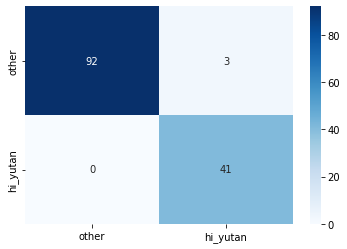

Thres - hold : 0.5
Test Accureacy:  0.9779411764705882
Test Precision:  0.9318181818181818
Test Recall:  1.0
Test F1 score:  0.9647058823529412
Val 에서 1의 비율 : 38.24%
Test 에서 1의 비율 : 30.15%
0.00025411213145536533
FPS :  3935.2705999227333


In [58]:
evaluate_tflite_model(tflite_file_path, model_type="Float")
test_model_time(tflite_file_path, model_type="Float")
# get_gzipped_model_size(tflite_file_path)
# 세로 - True
# 가로 - Prediction

Quantization model accuracy is 70.5882% (Number of test samples=136)


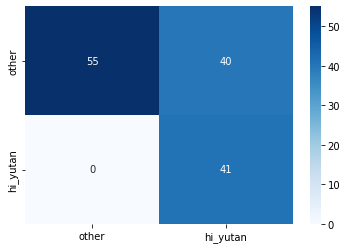

Thres - hold : 0.5
Test Accureacy:  0.7058823529411765
Test Precision:  0.5061728395061729
Test Recall:  1.0
Test F1 score:  0.6721311475409836
Val 에서 1의 비율 : 38.24%
Test 에서 1의 비율 : 30.15%
0.006719647084965426
FPS :  148.8173392673263


In [59]:
evaluate_tflite_model(quant_tflite_file_path, model_type="Quantization")
test_model_time(quant_tflite_file_path, model_type="Quantization")
# get_gzipped_model_size(quant_tflite_file_path)

In [ ]:
evaluate_tflite_model(prun_tflite_file_path, model_type="Pruning")
test_model_time(prun_tflite_file_path, model_type="Pruning")
get_gzipped_model_size(prun_tflite_file_path)

# 추론 과정

In [ ]:
# 기본 형태
import pyaudio
import numpy as np
 
CHUNK = 2**10  # 음성 데이터 불러올때, 한번에 몇개의 정수를 불러올지
RATE = 44100   # 음성 데이터의 sampleing rate , mfcc 에 나오는 거라 다른거니까 구분 해두기

# 음성 데이터 스트리을 여는 코드
"""
foramt : 비트 깊이를 설정 ,   여기서는 16bit가 된다
input : 우리가 지금 열려고 하는 것이기 떄문에 True
frames_per_buffer : 한번에 몇개의 정수를 불러올지
input_device_index : 원하는 입력 장치의 번호 (이거 없으면 자동으로 설정 해준다..)
"""
p=pyaudio.PyAudio()
stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True,
              frames_per_buffer=CHUNK,input_device_index=2)
 
# 음성 데이터를 입력받아 출력하는 소스
while(True):
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    print(int(np.average(np.abs(data))))
 
stream.stop_stream()
stream.close()
p.terminate()


ModuleNotFoundError: ignored

In [ ]:
"""
Connect a resistor and LED to board pin 8 and run this script.
Whenever you say "stop", the LED should flash briefly
"""

import sounddevice as sd
import numpy as np
import scipy.signal
import timeit
import python_speech_features
import RPi.GPIO as GPIO

from tflite_runtime.interpreter import Interpreter

# Parameters
debug_time = 1
debug_acc = 0
led_pin = 8
word_threshold = 0.5
rec_duration = 0.5 # 기동어 말 평균 길이로 하면 될듯 함
window_stride = 0.5 # 이거는 유지 해주기
sample_rate = 48000
resample_rate = 8000
num_channels = 1
num_mfcc = 40
model_path = base_path + 'wake_word_hi_yutan_lite.tflite'

# Sliding window
window = np.zeros(int(rec_duration * resample_rate) * 2)

# GPIO 
GPIO.setwarnings(False)
GPIO.setmode(GPIO.BOARD)
GPIO.setup(8, GPIO.OUT, initial=GPIO.LOW)

# Load model (interpreter)
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

# Decimate (filter and downsample)
def decimate(signal, old_fs, new_fs):
    
    # Check to make sure we're downsampling
    if new_fs > old_fs:
        print("Error: target sample rate higher than original")
        return signal, old_fs
    
    # We can only downsample by an integer factor
    dec_factor = old_fs / new_fs
    if not dec_factor.is_integer():
        print("Error: can only decimate by integer factor")
        return signal, old_fs

    # Do decimation
    resampled_signal = scipy.signal.decimate(signal, int(dec_factor))

    return resampled_signal, new_fs

# This gets called every 0.5 seconds
def sd_callback(rec, frames, time, status):

    GPIO.output(led_pin, GPIO.LOW)

    # Start timing for testing
    start = timeit.default_timer()
    
    # Notify if errors
    if status:
        print('Error:', status)
    
    # Remove 2nd dimension from recording sample
    rec = np.squeeze(rec)
    
    # Resample
    rec, new_fs = decimate(rec, sample_rate, resample_rate)
    
    # Save recording onto sliding window
    window[:len(window)//2] = window[len(window)//2:]
    window[len(window)//2:] = rec

    # Compute features
    mfccs = python_speech_features.base.mfcc(window, 
                                        samplerate=new_fs,
                                        winlen=0.256,
                                        winstep=0.050,
                                        numcep=num_mfcc,
                                        nfilt=26,
                                        nfft=2048,
                                        preemph=0.0,
                                        ceplifter=0,
                                        appendEnergy=False,
                                        winfunc=np.hanning)
    mfccs = mfccs.transpose()

    # Make prediction from model
    in_tensor = np.float32(mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1))
    interpreter.set_tensor(input_details[0]['index'], in_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    val = output_data[0][0]
    if val > word_threshold:
        print('stop')
        GPIO.output(led_pin, GPIO.HIGH)

    if debug_acc:
        print(val)
    
    if debug_time:
        print(timeit.default_timer() - start)

# Start streaming from microphone
with sd.InputStream(channels=num_channels,
                    samplerate=sample_rate,
                    blocksize=int(sample_rate * rec_duration),  # 1초에 프레임 * 녹화 하는 기간
                    callback=sd_callback):
    while True:
        pass

# TEMP

In [ ]:
"""
1.	D기동어 인식 개요
    1.	음성 인식 서비스 사례 – 케이티, 카카오, 구글 등 음성 인식 서비스 있음
    2.	문제점 및 해결 방안 – 서버에서 음성을 계속 받으면 비효율적 -> 기동어를 통해 서버와의 연결 제어
2.	Audio Processing
    1.	음성 신호 특성
    2.	Fourrier Transform (각 주파수 대역별에서의 에너지 크기 측정)
3.	기동어 인식 시스템 구조
4.	Mel Frequency Cepstral Coefficient (MFCC) 
    1.	Pe-emphasis
    2.	Fast Fourier Transform (FFT) – 위에 FT랑 다르게 프레임으로 쪼개어 변환 함 -> Spectrum  계획
        1.	Frequency domain의 feature를 형성, 보통 10 ~ 25ms 을 기준으로 함
        2.	Frame 간의 간격 = 5 ~ 10ms 로 설정
        3.	Frame 만들때 보통 Hamming Window를 통해 연속성 확보
        4.	Discrete Fourier Transorm(DFT)로  frame별 feature 추출  (주파수 별, 에너지 얼마나 있나)
    3.	Mel Spectrum ( 인간의 귀를 따라 만든 Mel-Filter Bank를 적용해서 Mel Spectrum 추출)
        1.	사람이 잘 들을 수 있는 저주파 영역을 확장
        2.	위에서 나온 DFT는 각 주파수에 해당하는 에너지 양을 보여줌
        3.	여기에다 고막의 특성을 적용(log를 통해) 하기 위해 Mel Filter Bank(각 주파수 별로 에너지 모음) 적용
        4.	이거를 DFT의 결과로 나온 주파수에 맞게 곱해줘서 나온 값에, Log를 적용(사람 귀)
    4.	Cepstral Analysis
        1.	Discrete Cosine Transform(DCT)을 통해 smoothing된 Fourier Transform 값 추출
        2.	3번까지 Frequency에 대한 값이지만, 다시 시간에 대한 값으로 표현
        3.	FFT 보다 연속성을 잘 표현 가능 (더 Smoothing 되었기 때문에 )
        4.	여기서 나온 값에서 첫 12개의(선택) MFCC Vector를 추출
    5.	MFCC Feature 생성ㅇㄹ
        1.	위 과정에서 나온거 중에 저주파(coefficient) 구간을 몇 개(N)를 볼 것인지 선택
5.	Deep Learning
6.	차주 계획

"""

In [ ]:
"""
# MFCC 추출 해주기
# https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sooftware&logNo=221661644808 참고

# frame 개수를 보여줌, output 세로
num_mfcc = 25
# output 가로
len_mfcc = 41
# input 음향 뒤에서 얼마나 잘라줄지
sample_cut = 20000

def get_librosa_mfcc(filepath):
  sampling_rate = 16000  # 1초에 몇개의 signal이 들어가 있는가
  hop_len = 500  # sig / hop_len 만큼 크기의 output 이 나옴
   # 들어오는 음향 길이 설정
  sig, sr = librosa.core.load(filepath, sampling_rate)
  # 뒤에서 부터 자르는게 더 좋을거 같음
  input_sig = sig[-sample_cut:]
  print("signal 크기 :",sig.shape)
  # log mell 찾아 보기
  # 120 만큼은 겹치게 된다.
  mfccs = librosa.feature.mfcc(y = input_sig, sr = sr, hop_length =hop_len, n_mfcc = num_mfcc, n_fft = 512 )
  return mfccs



print("Model input size = ( {} x {} x {})".format(num_mfcc, len_mfcc, 1))


# n_mfcc : 음성데이터를 어느 단위로 쪼갤지 (사람은 20 ~ 40 ms 까지는 음소가 바뀌지 못함 - 말 자르는 가장 작은 단위 == frame_size
# n_fft : frame의 length = window size,   잘린 음석이 n_ftt보다 작으면 0으로 Padding 해줌, 
   # n_fft는 winddow size보다 크거나 같아야함
   # n_ftt = 8000 * 0.040 = 320
# hop_legth : window 얼마 만큼씩 움질일 것인가

  # n_mfcc = 40
  # hop_length = 200  # 8000 * 0.040
  # N_FFT = 320    # 8000 * 0.040

# 이거 기준으로 나눈 다음에 Mel값을 뽑아서 Feature로 사용하게 된다.  (  50%는 겹치게 분할을 진행)
# 각각의 frame에 대해서 Hamming Window 적용해서 연속성 맞춰주기 - Default 설정임
# 각 프레임에 대하여 Fourier Transform 적용해서(FFT) 주파서 성분 알아내기
# Mel Filter Banb(삶귀처럼, 주파수 증가할수록 큰 삼각형 filter가 생각다고 생각하기)
# 여기까지하면 Mel-Spectrogram Feature가 추출된다.

# Mel-Spectrogram 을 압축해서 표현해주는 DCT 연산 수행 -> Discrete Cosine Transform
"""


Model input size = ( 25 x 41 x 1)
